In [1]:
# Imports
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.drivers import Molecule, UnitsType
from qiskit_nature.drivers.second_quantization import PySCFDriver, ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit import Aer, IBMQ
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram, plot_circuit_layout, plot_gate_map

import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
# Load IBMQ account
try:
    IBMQ.load_account()
except:
    token = input("Please enter your IBMQ token: ")
    IBMQ.save_account(token)

# Load provider
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='uminho-1', project='main')

# Quantum Chemistry
## Finding the minimum energy of molecules
---
Class of Quantum Computation of University of Minho (2022/2023)


#### Authors:
- Maria Gabriela Jordão Oliveira, pg50599
- Miguel Caçador Peixoto, pg50657

## Define diferent backends & devices

In [3]:
# Choose the "perfect" simulator
statevector_simulator = Aer.get_backend("statevector_simulator")

# Choose the real device
real_device = provider.get_backend('ibm_perth')

# Create a simulator from the real device
simulator_device = AerSimulator.from_backend(real_device)

/home/mcpeixoto/Desktop/Quantum-Chemistry/.env/lib/python3.10/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (186064.81242819485 > 2 * 89549.87196202418). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/mcpeixoto/Desktop/Quantum-Chemistry/.env/lib/python3.10/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (186064.81242819485 > 2 * 89549.87196202418). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/mcpeixoto/Desktop/Quantum-Chemistry/.env/lib/python3.10/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoreti

In [4]:
# Exact solver for comparison
def exact_solver(problem, converter):
    '''
    This function finds the exact solution for a given problem and converter.
    This is a pure classical solver.
    '''
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

## General Functions (Prepwork)

In [5]:
def get_generic_qubit_op(molecule_geometry, multiplicity, charge, basis = None, remove_orbitals=None):
    '''
    Args:
    molecule_geometry : Molecule geometry. List of lists. First element of each list is the atom name, second element is the coordinates.
    multiplicity : Multiplicity. 2*spin + 1
    charge : Charge of the molecule
    basis : Basis set. Default is sto3g
    remove_orbitals : List of orbitals to remove. Default is None. Please unsure that the orbitals are not occupied.
    
    Returns:
    qubit_op : Qubit operator
    num_particles : Number of particles
    num_spin_orbitals : Number of spin orbitals
    problem : Problem. Electronic structure problem with driver and transformers. Freeze core transformation is used.
    converter : Converter. Qubit converter with parity mapper and two qubit reduction.
    '''
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry= molecule_geometry,
        multiplicity= multiplicity,  # = 2*spin + 1
        charge= charge,
    )

    if basis is None:
        basis = "sto3g"
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis= basis,
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True, remove_orbitals=remove_orbitals)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    # Get Hamiltonian
    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True )
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter


def run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, qi, quantum_instance, var_form):
    """
    Args:
    distances : List of distances
    molecule_geometry : Molecule geometry. List of lists. First element of each list is the atom name, second element is the coordinates.
    multiplicity : Multiplicity. 2*spin + 1
    charge : Charge of the molecule
    remove_orbitals : List of orbitals to remove. Default is None. Please unsure that the orbitals are not occupied.
    optimizer : Optimizer
    qi : Quantum Instance

    Returns:
    exact_energies : List of exact energies
    vqe_energies : List of vqe energies
    """

    exact_energies = []
    vqe_energies = []
    for dist in distances:
        (qubit_op, num_particles, num_spin_orbitals, problem, converter) = get_generic_qubit_op(molecule_geometry(dist), multiplicity, charge, remove_orbitals=remove_orbitals)
        
        ######################
        ### Exact Solution ###
        ######################
        result = exact_solver(problem,converter)
        exact_energies.append(result.total_energies[0].real)

        ######################
        ### VQE Solution #####
        ######################

        # Var Form
        if var_form == "UCCSD":
            init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
            var_form = UCCSD(converter, num_particles, num_spin_orbitals, initial_state=init_state)
        elif var_form == "SU2":
            var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")

        # VQE
        vqe = VQE(var_form, optimizer=optimizer, quantum_instance=quantum_instance)
        vqe_calc=vqe.compute_minimum_eigenvalue(qubit_op)
        vqe_result=np.real(problem.interpret(vqe_calc).total_energies)
        vqe_energies.append(vqe_result)
        print(f"Interatomic Distance: {np.round(dist, 2)}", f"VQE Result: {vqe_result[0]:.5f}", f"Exact Energy: {exact_energies[-1]:.5f}")

    print("All energies have been calculated")
    return exact_energies, vqe_energies

def plot_energies(distances, exact_energies, vqe_energies, title):
    """
    Args:
    distances : List of distances
    exact_energies : List of exact energies
    vqe_energies : List of vqe energies
    title : Title of the plot
    """
    plt.plot(distances, exact_energies, label="Exact Energy")
    plt.plot(distances, vqe_energies, label="VQE Energy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy')
    plt.title(title)
    plt.legend()
    plt.show()
    

# Simulation

## H2
Expected energy: -1.117506  hartree

Expected bond length: 0.712 Angstrom

In [6]:
# Defining fixed parameters
molecule_geometry = lambda dist:[
            ["H", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ]
multiplicity = 1
charge = 0
remove_orbitals = []
distances = np.arange(0.5, 3.0, 0.2)

### Using UCCSD ansatz and SLSQP optimizer

#### Perfect device

Interatomic Distance: 0.5 VQE Result: -1.05516 Exact Energy: -1.05516
Interatomic Distance: 0.7 VQE Result: -1.13619 Exact Energy: -1.13619
Interatomic Distance: 0.9 VQE Result: -1.12056 Exact Energy: -1.12056
Interatomic Distance: 1.1 VQE Result: -1.07919 Exact Energy: -1.07919
Interatomic Distance: 1.3 VQE Result: -1.03519 Exact Energy: -1.03519
Interatomic Distance: 1.5 VQE Result: -0.99815 Exact Energy: -0.99815
Interatomic Distance: 1.7 VQE Result: -0.97143 Exact Energy: -0.97143
Interatomic Distance: 1.9 VQE Result: -0.95434 Exact Energy: -0.95434
Interatomic Distance: 2.1 VQE Result: -0.94437 Exact Energy: -0.94437
Interatomic Distance: 2.3 VQE Result: -0.93892 Exact Energy: -0.93892
Interatomic Distance: 2.5 VQE Result: -0.93605 Exact Energy: -0.93605
Interatomic Distance: 2.7 VQE Result: -0.93458 Exact Energy: -0.93458
Interatomic Distance: 2.9 VQE Result: -0.93385 Exact Energy: -0.93385
All energies have been calculated


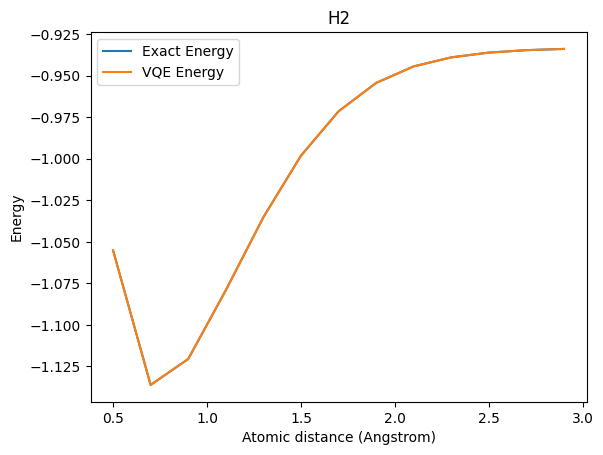

In [7]:
optimizer = SLSQP(maxiter=20)
var_form = "UCCSD"
quantum_instance = statevector_simulator

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2")

#### Noisy simulator

Interatomic Distance: 0.5 VQE Result: 0.01133 Exact Energy: -1.05516
Interatomic Distance: 0.7 VQE Result: -0.51304 Exact Energy: -1.13619
Interatomic Distance: 0.9 VQE Result: -0.21584 Exact Energy: -1.12056
Interatomic Distance: 1.1 VQE Result: -0.72118 Exact Energy: -1.07919
Interatomic Distance: 1.3 VQE Result: -0.64785 Exact Energy: -1.03519
Interatomic Distance: 1.5 VQE Result: -0.70751 Exact Energy: -0.99815
Interatomic Distance: 1.7 VQE Result: -0.57826 Exact Energy: -0.97143
Interatomic Distance: 1.9 VQE Result: -0.73839 Exact Energy: -0.95434
Interatomic Distance: 2.1 VQE Result: -0.71358 Exact Energy: -0.94437
Interatomic Distance: 2.3 VQE Result: -0.65724 Exact Energy: -0.93892
Interatomic Distance: 2.5 VQE Result: -0.50422 Exact Energy: -0.93605
Interatomic Distance: 2.7 VQE Result: -0.54661 Exact Energy: -0.93458
Interatomic Distance: 2.9 VQE Result: -0.55151 Exact Energy: -0.93385
All energies have been calculated


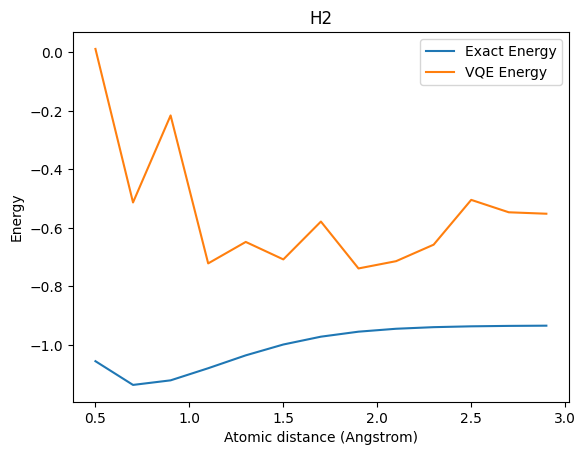

In [8]:
optimizer = SLSQP(maxiter=20)
var_form = "UCCSD"
quantum_instance = simulator_device

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2")

### Using SU2 ansatz and SPSA optimizer

#### Perfect device

Interatomic Distance: 0.5 VQE Result: -0.98336 Exact Energy: -1.05516
Interatomic Distance: 0.7 VQE Result: -1.10425 Exact Energy: -1.13619
Interatomic Distance: 0.9 VQE Result: -1.09708 Exact Energy: -1.12056
Interatomic Distance: 1.1 VQE Result: -0.94443 Exact Energy: -1.07919
Interatomic Distance: 1.3 VQE Result: -0.99251 Exact Energy: -1.03519
Interatomic Distance: 1.5 VQE Result: -0.95313 Exact Energy: -0.99815
Interatomic Distance: 1.7 VQE Result: -0.93414 Exact Energy: -0.97143
Interatomic Distance: 1.9 VQE Result: -0.92995 Exact Energy: -0.95434
Interatomic Distance: 2.1 VQE Result: -0.93988 Exact Energy: -0.94437
Interatomic Distance: 2.3 VQE Result: -0.92080 Exact Energy: -0.93892
Interatomic Distance: 2.5 VQE Result: -0.93236 Exact Energy: -0.93605
Interatomic Distance: 2.7 VQE Result: -0.93114 Exact Energy: -0.93458
Interatomic Distance: 2.9 VQE Result: -0.93240 Exact Energy: -0.93385
All energies have been calculated


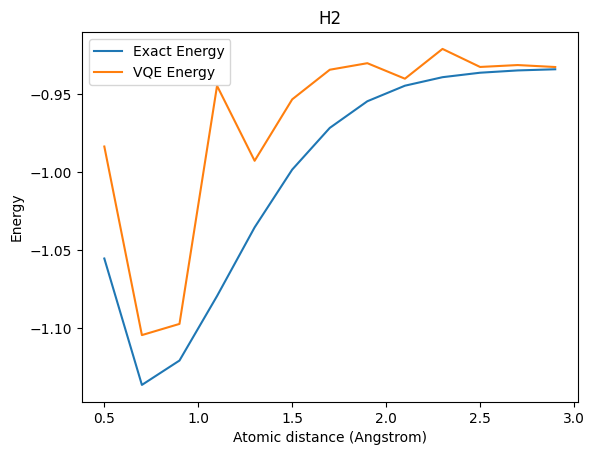

In [9]:
optimizer = SPSA(maxiter=20)
var_form = "SU2"
quantum_instance = statevector_simulator

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2")

#### Noisy simulator

In [10]:
optimizer = SPSA(maxiter=20)
var_form = "SU2"
quantum_instance = simulator_device

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2")

Interatomic Distance: 0.5 VQE Result: -0.28895 Exact Energy: -1.05516
Interatomic Distance: 0.7 VQE Result: -0.90542 Exact Energy: -1.13619
Interatomic Distance: 0.9 VQE Result: -0.96795 Exact Energy: -1.12056
Interatomic Distance: 1.1 VQE Result: -0.90722 Exact Energy: -1.07919
Interatomic Distance: 1.3 VQE Result: -0.97685 Exact Energy: -1.03519
Interatomic Distance: 1.5 VQE Result: -0.92221 Exact Energy: -0.99815
Interatomic Distance: 1.7 VQE Result: -0.92912 Exact Energy: -0.97143


## NaH
Expected energy: -160.315703 hartree

Expected bond length: 1.654 Angstrom

In [ ]:
# Defining fixed parameters
molecule_geometry = lambda dist:[
            ["Na", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ]
multiplicity = 1
charge = 0

### Using UCCSD ansatz and SLSQP optimizer

#### Perfect device

In [ ]:
optimizer = SLSQP(maxiter=20)
var_form = "UCCSD"
quantum_instance = statevector_simulator

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2")

#### Noisy simulator

In [ ]:
optimizer = SLSQP(maxiter=20)
var_form = "UCCSD"
quantum_instance = simulator_device

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2")

### Using SU2 ansatz and SPSA optimizer

#### Perfect device

In [ ]:
optimizer = SPSA(maxiter=20)
var_form = "SU2"
quantum_instance = statevector_simulator

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2")

#### Noisy simulator

In [ ]:
optimizer = SPSA(maxiter=20)
var_form = "SU2"
quantum_instance = simulator_device

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2")

## BeH2
Expected energy: -15.561353 hartree

Expected bond length: 1.291 Angstrom

In [ ]:
# Defining fixed parameters
molecule_geometry = lambda dist:[
            ["Be", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]],
            ["H", [-dist, 0.0, 0.0]]
        ]
multiplicity = 1
charge = 0

### Using UCCSD ansatz and SLSQP optimizer

#### Perfect device

In [ ]:
optimizer = SLSQP(maxiter=20)
var_form = "UCCSD"
quantum_instance = statevector_simulator

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2")

#### Noisy simulator

In [ ]:
optimizer = SLSQP(maxiter=20)
var_form = "UCCSD"
quantum_instance = simulator_device

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2")

### Using SU2 ansatz and SPSA optimizer

#### Perfect device

In [ ]:
optimizer = SPSA(maxiter=20)
var_form = "SU2"
quantum_instance = statevector_simulator

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2")

#### Noisy simulator

In [ ]:
optimizer = SPSA(maxiter=20)
var_form = "SU2"
quantum_instance = simulator_device

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2")

# Real Quantum Computer

With error mitigation

## H2

In [ ]:
raise KeyboardInterrupt # So that we don't run the following cells accidentally

In [ ]:
# Defining fixed parameters
molecule_geometry = lambda dist:[
            ["H", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ]
multiplicity = 1
charge = 0
remove_orbitals = []
# Reduced number of possible distances
distances = np.arange(0.5, 1.1, 0.2)

#### Defining device with error mitigation

In [ ]:
coupling_map = real_device.configuration().coupling_map
quantum_instance = QuantumInstance(
    real_device,
    measurement_error_mitigation_cls=CompleteMeasFitter
    )

#### Run on real quantum computer

We will use SU2 ansatz and SPSA optimizer

In [ ]:
optimizer = SPSA(maxiter=20)
var_form = "SU2"

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2")